In [1]:
import numpy as np 
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras import layers

import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
rating100 = pd.read_csv("/kaggle/input/movielens-100k-dataset/ml-100k/u.data",
                        sep="\t",
                        names=["user_id", "item_id", "rating", "timestamp"])

In [3]:
rating100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [4]:
rating100.describe()

,user_id,item_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


In [5]:
rating100["user_id"].value_counts()

405    737
655    685
13     636
450    540
276    518
      ... 
441     20
36      20
812     20
895     20
93      20
Name: user_id, Length: 943, dtype: int64

In [6]:
def create_sequences(values, window_size, step_size):
    sequences = []
    targets = []
    start_index = 0
    while True:
        end_index = start_index + window_size
        seq = values[start_index:end_index]
        if len(seq) < window_size:
            seq = values[-window_size:]
            if len(seq) == window_size:
                sequences.append(seq[:-1])
                targets.append(seq[-1:])
            break
        sequences.append(seq[:-1])
        targets.append(seq[-1:])
        start_index += step_size
    return list(sequences), list(targets)

def make_data_dict(df, w=6, s=2):
    df_sorted = df.sort_values(by=["user_id", "timestamp"])
    df_group = df_sorted.groupby("user_id")

    df_data = pd.DataFrame(
        data={
            "user_id": list(df_group.groups.keys()),
            "item_ids": list(df_group.item_id.apply(list)),
            "ratings": list(df_group.rating.apply(list)),
            "timestamps": list(df_group.timestamp.apply(list)),
        }
    )

    df_data["sequence_item_ids"] = df_data.item_ids.apply(
        lambda ids: create_sequences(ids, w, s)[0]
    )

    df_data["target_item"] = df_data.item_ids.apply(
        lambda ids: create_sequences(ids, w, s)[1]
    )

    df_data["sequence_ratings"] = df_data.ratings.apply(
        lambda ids: create_sequences(ids, w, s)[0]
    )

    df_data["target_rating"] = df_data.ratings.apply(
        lambda ids: create_sequences(ids, w, s)[1]
    )

    df_data_items = df_data[["user_id", "sequence_item_ids"]].explode("sequence_item_ids", ignore_index=True)
    df_data_t_item = df_data["target_item"].explode("target_item").apply(lambda x : x[0])
    df_data_rating = df_data["sequence_ratings"].explode("sequence_ratings")
    df_data_t_rating = df_data["target_rating"].explode("target_rating").apply(lambda x : x[0])

    df_data_items = pd.concat([df_data_items,
                               df_data_rating,
                               df_data_t_item,
                               df_data_t_rating], axis=1)

    data_dict = {
            "user_id": list(df_data_items.user_id),
            "item_ids": list(df_data_items.sequence_item_ids),
            "target_id": list(df_data_items.target_item),
            "ratings": list(df_data_items.sequence_ratings),
            "target": list(df_data_items.target_rating),
        }
    
    return data_dict

def create_batch_data(data_set, test=False, batch=128):
    
    max_user = 943
    max_item = 1682
    max_rating = 5
    
    features = {"user_id": tf.one_hot(data_set["user_id"], max_user),
                "item_ids": tf.one_hot(data_set["item_ids"], max_item),
                "ratings" :  tf.one_hot(data_set["ratings"], max_rating),
                "target_id" : tf.one_hot(data_set["target_id"], max_item)}
    if test:
        batch_data = tf.data.Dataset.from_tensor_slices(dict(features))
    else:
        target = data_set["target"]
        batch_data = tf.data.Dataset.from_tensor_slices((dict(features), target))
    
    batch_data = batch_data.batch(batch)

    return batch_data
        
def lstm_model(hparams):
    input_user = layers.Input(shape=(hparams["max_user"],),
                              name="user_id",
                              dtype=tf.float32)
    input_item = layers.Input(shape=(hparams["n_time"]-1, hparams["max_item"]),
                              name="item_ids",
                              dtype=tf.float32)
    input_target = layers.Input(shape=(hparams["max_item"],),
                                name="target_id",
                                dtype=tf.float32)
    input_rating = layers.Input(shape=(hparams["n_time"]-1, hparams["max_rating"]),
                                name="ratings",
                                dtype=tf.float32)
    
    input_list = [input_item, input_user, input_target, input_rating]
    repeated_input_user = layers.RepeatVector(hparams["n_time"]-1)(input_user)
    repeated_input_target = layers.RepeatVector(hparams["n_time"]-1)(input_target)
    
    item_processor = layers.Dense(hparams["latent_dim"], activation="relu")(input_item)
    rating_processor = layers.Dense(hparams["latent_dim"], activation="relu")(input_rating)
    target_processor = layers.Dense(hparams["latent_dim"], activation="relu")(repeated_input_target)
    user_processor = layers.Dense(hparams["latent_dim"], activation="relu")(repeated_input_user)
    
    concat_inputs = layers.Concatenate()(
        [item_processor, user_processor, target_processor, rating_processor]
    )
    
    concat_inputs = layers.BatchNormalization()(concat_inputs)
    x = layers.LSTM(units=hparams["lstm_unit"],
                    return_sequences=True)(concat_inputs)
    x = layers.Dropout(hparams["dropout"])(x)
    x = layers.BatchNormalization()(x)
    z = layers.Attention(use_scale=False,
                         causal=True)(inputs=[x, x])
    z = layers.LSTM(units=hparams["lstm_unit"],
                    return_sequences=False)(z)
        
    output = layers.Dense(1)(z)
    model = keras.Model(input_list, output)
    
    return model

def transformer_model(hparams):
    input_user = layers.Input(shape=(hparams["max_user"],),
                              name="user_id",
                              dtype=tf.float32)
    input_item = layers.Input(shape=(hparams["n_time"]-1, hparams["max_item"]),
                              name="item_ids",
                              dtype=tf.float32)
    input_target = layers.Input(shape=(hparams["max_item"],),
                                name="target_id",
                                dtype=tf.float32)
    input_rating = layers.Input(shape=(hparams["n_time"]-1, hparams["max_rating"]),
                                name="ratings",
                                dtype=tf.float32)

    positional_input = tf.one_hot(
        tf.range(start=0, limit=hparams["n_time"]-1, delta=1), hparams["n_time"]-1
    )
    
    positional_processor = layers.Dense(hparams["latent_dim"], activation="relu")(positional_input)
    item_processor = layers.Dense(hparams["latent_dim"], activation="relu")(input_item)
    rating_processor = layers.Dense(hparams["latent_dim"], activation="relu")(input_rating)
    target_processor = layers.Dense(hparams["latent_dim"], activation="relu")(input_target)
    user_processor = layers.Dense(hparams["latent_dim"], activation="relu")(input_user)
    
    multi_inputs = layers.Multiply()([(item_processor + positional_processor), rating_processor])
    transformer_inputs = []
    for encoded_item in tf.unstack(multi_inputs, axis=1):
        transformer_inputs.append(tf.expand_dims(encoded_item, 1))
    transformer_inputs.append(tf.expand_dims(target_processor, 1))
    concatted_inputs = layers.concatenate(transformer_inputs, axis=1)
    input_list = [input_item, input_user, input_target, input_rating]
    attention_output = layers.MultiHeadAttention(
        num_heads=hparams["num_heads"], key_dim=concatted_inputs.shape[2], dropout=hparams["dropout"]
    )(concatted_inputs, concatted_inputs)
    attention_output = layers.Dropout(hparams["dropout"])(attention_output)
    
    x1 = layers.Add()([concatted_inputs, attention_output])
    x1 = layers.LayerNormalization()(x1)
    x2 = layers.LeakyReLU()(x1)
    x2 = layers.Dense(units=x2.shape[-1])(x2)
    x2 = layers.Dropout(hparams["dropout"])(x2)
    transformer_features = layers.Add()([x1, x2])
    transformer_features = layers.LayerNormalization()(transformer_features)
    features = layers.Flatten()(transformer_features)
    features = layers.concatenate([features, user_processor])
    features = layers.Dense(hparams["dense_units"])(features)
    features = layers.BatchNormalization()(features)
    features = layers.LeakyReLU()(features)
    features = layers.Dropout(hparams["dropout"])(features)
    output = layers.Dense(1)(features)
    model = keras.Model(input_list, output)
    
    return model

def matrix_factorization(hparams):
    user_input = layers.Input(shape=(1,), dtype=tf.int32)
    item_input = layers.Input(shape=(1,), dtype=tf.int32)

    user_embedding = layers.Embedding(hparams["max_user"]+1,
                                      hparams["latent_dim"])(user_input)

    user_vector = layers.Flatten()(user_embedding)

    item_embedding = layers.Embedding(hparams["max_item"]+1,
                                      hparams["latent_dim"])(item_input)

    item_vector = layers.Flatten()(item_embedding)

    dot_user_item = layers.Dot(axes=1)([user_vector, item_vector])
    model = keras.Model([user_input, item_input], dot_user_item)
    
    if hparams["model-type"]=="ncf":
        X = layers.Flatten()(dot_user_item)

        concatenated = layers.Concatenate()([user_embedding, item_embedding])
        Y = layers.Flatten()(concatenated)
        Y = layers.Dense(hparams["dense_units"],
                         activation="relu",
                         kernel_regularizer=keras.regularizers.l2(0.001))(Y)
        Y = layers.Dropout(hparams["dropout"])(Y)
        Y = layers.BatchNormalization()(Y)

        Y = layers.Dense(1,)(Y)

        Z = layers.Add()([X, Y])

        model = keras.Model([user_input, item_input], Z)
        
    return model

def model_training(model, train_set, val_set, verbose=0):
  
    es = keras.callbacks.EarlyStopping(monitor="val_loss",
                                       mode="min",
                                       verbose=1,
                                       patience=3)
    
    hist = model.fit(train_set,
                     epochs=200,
                     verbose=verbose,
                     validation_data=val_set,
                     callbacks=[es])
    
    return hist

In [7]:
VAL_SIZE = 0.2

df_sorted = rating100.sort_values(by=["user_id", "timestamp"])
train_time = df_sorted.groupby("user_id").agg({"timestamp": lambda x: list(x)[:-1]}).explode("timestamp")

target_item = df_sorted.groupby("user_id").agg({"item_id": lambda x: list(x)[-1]})
target_item.rename(columns={"item_id":"target_id"}, inplace=True)

train_item = df_sorted.groupby("user_id").agg({"item_id": lambda x: list(x)[:-1]})

target_rating = df_sorted.groupby("user_id").agg({"rating": lambda x: list(x)[-1]})
target_rating.rename(columns={"rating":"target"}, inplace=True)

train_rating = df_sorted.groupby("user_id").agg({"rating": lambda x: list(x)[:-1]}).explode("rating")

train_data = pd.concat([target_item, train_item, target_rating], axis=1).explode("item_id")
train_data = pd.concat([train_data, train_rating, train_time], axis=1).reset_index()

user_base = train_data["user_id"].unique()
random_selection = np.random.rand(len(user_base)) <= VAL_SIZE
val_user = user_base[random_selection]
val_data = rating100[rating100["user_id"].isin(val_user)]

print("total users:", train_data["user_id"].nunique())
print("validation users:", val_data["user_id"].nunique())

total users: 943
validation users: 179


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None, 943)]        0           []                               
                                                                                                  
 target_id (InputLayer)         [(None, 1682)]       0           []                               
                                                                                                  
 item_ids (InputLayer)          [(None, 4, 1682)]    0           []                               
                                                                                                  
 repeat_vector (RepeatVector)   (None, 4, 943)       0           ['user_id[0][0]']                
                                                                                              

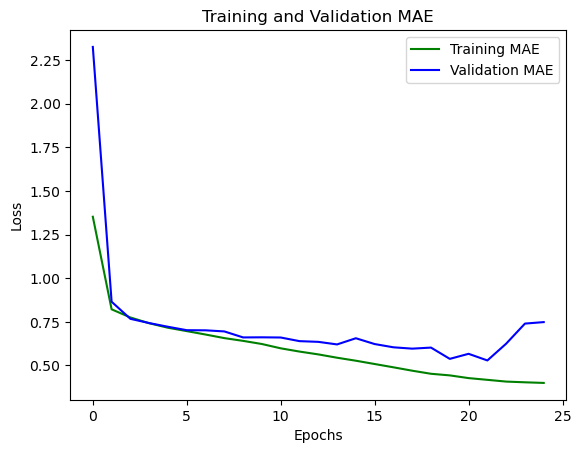

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 item_ids (InputLayer)          [(None, 4, 1682)]    0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 4, 512)       861696      ['item_ids[0][0]']               
                                                                                                  
 ratings (InputLayer)           [(None, 4, 5)]       0           []                               
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 4, 512)      0           ['dense_6[0][0]']                
 da)                                                                                        

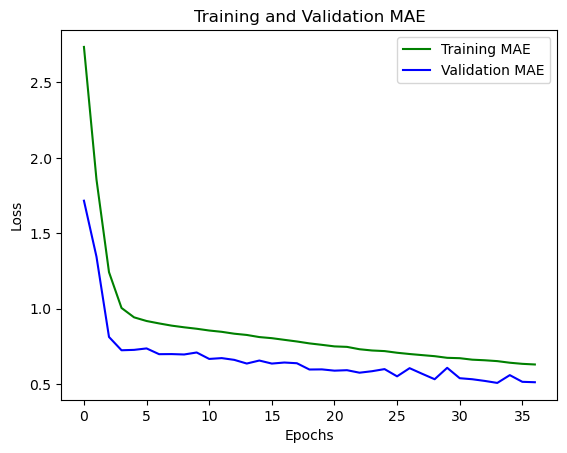

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 128)       120832      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 128)       215424      ['input_2[0][0]']                
                                                                                            

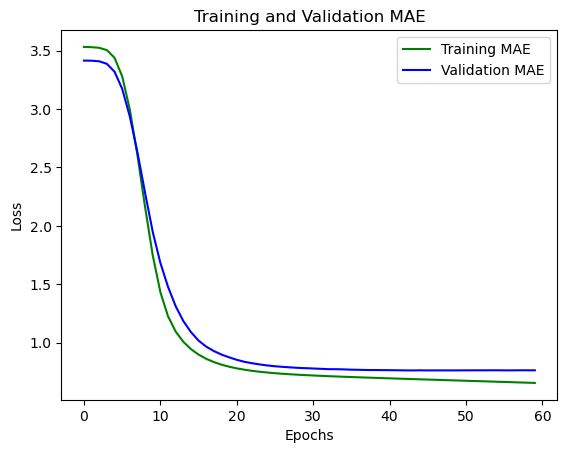

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 128)       120832      ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 128)       215424      ['input_4[0][0]']                
                                                                                            

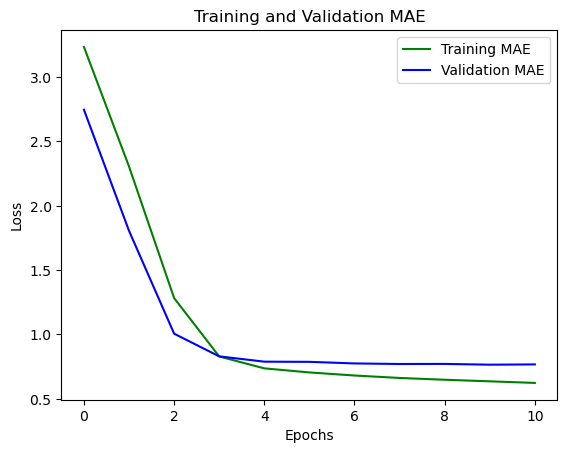

In [8]:
BATCH_SIZE = 256
N_TIME = 5
STEP_SIZE = 2

max_user = rating100["user_id"].max()
max_item = rating100["item_id"].max()
max_rating = rating100["rating"].max()

hparams = {
    "n_time": N_TIME,
    "max_user": max_user,
    "max_item": max_item,
    "max_rating": max_rating,
}

exp_df = pd.DataFrame(columns=["model-type", "train_mae", "train_loss",
                               "val_mae", "val_loss"])
model_types = ["rnn-lstm", "transformer", "mf", "ncf"]
for m in model_types:
    hparams["model-type"] = m
    if (hparams["model-type"]=="transformer") or (hparams["model-type"]=="rnn-lstm"):

        train_set = make_data_dict(train_data, N_TIME, STEP_SIZE)
        val_set = make_data_dict(val_data, N_TIME, STEP_SIZE)
        train_set_ = create_batch_data(train_set, batch=BATCH_SIZE)
        val_set_ = create_batch_data(val_set, batch=BATCH_SIZE)

        if hparams["model-type"]=="transformer":
            hparams["num_heads"] = 3
            hparams["latent_dim"] = 512
            hparams["dense_units"] = 128
            hparams["dropout"] = 0.2
            hparams["learning"] = 0.0001
            model = transformer_model(hparams)
        else:
            hparams["lstm_unit"] = 400
            hparams["latent_dim"] = 256
            hparams["dropout"] = 0.6
            hparams["learning"] = 0.0001
            model = lstm_model(hparams)

        model.compile(loss=keras.losses.MeanSquaredError(),
                      optimizer=keras.optimizers.Adam(learning_rate=hparams["learning"]),
                      metrics=["mean_absolute_error"])

        model.summary()
        hist = model_training(model, train_set_, val_set_, verbose=1)

    else:
        train_set = train_data[["user_id", "item_id", "rating"]]
        train_set = train_set.astype(int)
        val_data = train_data[["user_id", "target_id", "target"]].drop_duplicates()
        val_set = val_data[val_data["user_id"].isin(val_user)]

        hparams["latent_dim"] = 128
        hparams["dense_units"] = 128
        hparams["dropout"] = 0.2
        hparams["learning"] = 0.0001

        model = matrix_factorization(hparams)

        model.compile(loss=keras.losses.MeanSquaredError(),
                      optimizer=keras.optimizers.Adam(learning_rate=hparams["learning"]),
                      metrics=["mean_absolute_error"])

        model.summary()

        es = keras.callbacks.EarlyStopping(monitor="val_loss",
                                           mode="min",
                                           verbose=1,
                                           patience=3)

        hist = model.fit([train_set["user_id"].values,train_set["item_id"].values],train_set["rating"].values,
                         epochs=200,
                         verbose=1,
                         batch_size=BATCH_SIZE,
                         validation_data=([val_set["user_id"].values,val_set["target_id"].values],val_set["target"].values),
                         callbacks=[es])

    train_mae = hist.history["mean_absolute_error"][-1]
    train_loss = hist.history["loss"][-1]
    val_mae = hist.history["val_mean_absolute_error"][-1]
    val_loss = hist.history["val_loss"][-1]
    model_result = {
        "model-type": m,
        "train_mae": train_mae,
        "train_loss": train_loss,
        "val_mae": val_mae,
        "val_loss": val_loss
    }
    model_result = pd.DataFrame([model_result])
    exp_df = pd.concat([exp_df, model_result], ignore_index=True)
    
    epochs = range(1, len(hist.history["loss"]))
    plt.plot(hist.history["mean_absolute_error"], 'g', label='Training MAE')
    plt.plot(hist.history["val_mean_absolute_error"], 'b', label='Validation MAE')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

file = "".join(np.random.choice(["a", "b", "c", "d", "e", 0, 1, 2, 3, 4], 4))
exp_df.to_csv("val_split_" + file + ".csv", sep=";", index=False)